In [1]:
import numpy as np 
import pandas as pd 
import re 
import nltk 
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

In [3]:
data = pd.read_csv("./train_hu.csv",encoding='latin-1')

data.head()

,tweet,class
0,RT : N?ként nem szabadna panaszkodnod a takarí...,2
1,"RT Dawg RT : Dugtál már valaha egy ribancot, ...",1
2,"RT : úgy néz ki, mint egy transzvesztita",1
3,"RT : A szar, amit rólam hallasz, lehet, hogy ...",1
4,: A szar csak fújja meclaim te olyan h?séges é...,1


In [4]:
data.rename(columns={'tweet': 'text'}, inplace=True)

In [5]:
data['text']=data['text'].apply(str)

In [6]:
print(f"num of texts: {data.shape}")

# extract the text and labels
tweet = list(data['text'])
labels = list(data['class'])

num of texts: (7741, 2)


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
# Load Romanian stopwords from file
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_hu = file.read().splitlines()
    return set(stopwords_hu)

stopwords_hu = load_stopwords("./hungarian.txt")

# Function to remove Romanian stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if word.lower() not in stopwords_hu]
    text = " ".join(text)
    return text

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

## this function in to clean all the dataset by utilizing all the function above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean


# data.head()

In [9]:
# call the cleaning function
clean_tweet = preprocess(tweet)


4 | Splitting the dataset into test and validation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [11]:
# declare the tokenizer
tokenizer = Tokenizer()
# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)
# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [12]:
## Padding -> to uniform the datas
max_length = max(len(seq) for seq in X_train)
print(max_length)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

30


In [13]:
# create hot_labels
y_test = to_categorical(y_test, num_classes=3)
y_train = to_categorical(y_train, num_classes=3)

In [14]:
# another look on the number of tweet in test and training data

print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 1549
num train tweet: 6192


5 | Building the Model

In [15]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [16]:
output_dim = 200

# LSTM model architechture
model = Sequential([
    # embedding layer
    Embedding(vocab_size, output_dim, input_length=max_length),
    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    # dropout to prevent overfitting
    Dropout(0.5),
    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),
    # dropout to prevent overfitting
    Dropout(0.5),
    # this is output layer, with 4 class (0, 1, 2, 3)
    Dense(3, activation="softmax"),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [17]:
# checking the model parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           2820400   
                                                                 
 lstm (LSTM)                 (None, 64)                67840     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2896947 (11.05 MB)
Trainable params: 28969

In [ ]:
# Train the model
model_history = model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
97/97 [==============================] - 16s 122ms/step - loss: 0.7547 - accuracy: 0.7387 - f1: 0.6810 - precision: 0.7003 - recall: 0.6717 - val_loss: 0.6196 - val_accuracy: 0.7515 - val_f1: 0.7573 - val_precision: 0.7596 - val_recall: 0.7550
Epoch 2/10
97/97 [==============================] - 11s 117ms/step - loss: 0.4624 - accuracy: 0.8215 - f1: 0.8148 - precision: 0.8842 - recall: 0.7582 - val_loss: 0.5715 - val_accuracy: 0.8025 - val_f1: 0.8065 - val_precision: 0.8262 - val_recall: 0.7881
Epoch 3/10
97/97 [==============================] - 12s 123ms/step - loss: 0.2335 - accuracy: 0.9136 - f1: 0.9148 - precision: 0.9348 - recall: 0.8959 - val_loss: 0.6256 - val_accuracy: 0.8031 - val_f1: 0.8053 - val_precision: 0.8313 - val_recall: 0.7813
Epoch 4/10
97/97 [==============================] - 11s 118ms/step - loss: 0.1073 - accuracy: 0.9643 - f1: 0.9642 - precision: 0.9678 - recall: 0.9605 - val_loss: 0.7860 - val_accuracy: 0.7915 - val_f1: 0.7927 - val_precision: 0.8000 -

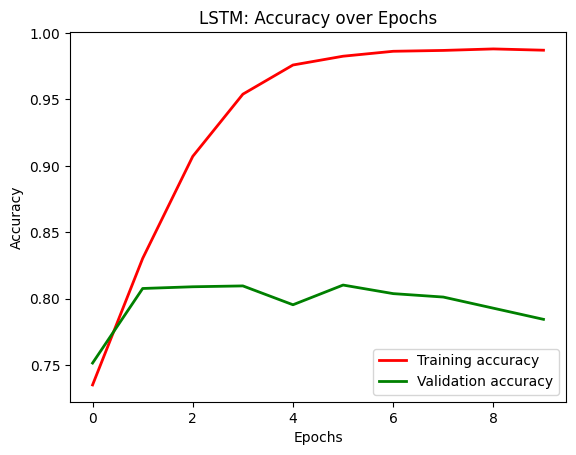

In [20]:
import matplotlib.pyplot as plt

# Extract history
hist = model_history.history

# Plot training and validation accuracy
plt.plot(hist['accuracy'], 'r', linewidth=2, label='Training accuracy')
plt.plot(hist['val_accuracy'], 'g', linewidth=2, label='Validation accuracy')
plt.title('LSTM: Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(np.argmax(y_test, axis=1), y_pred))

49/49 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.39      0.37      0.38       130
           1       0.85      0.91      0.88      1159
           2       0.73      0.50      0.60       260

    accuracy                           0.80      1549
   macro avg       0.65      0.59      0.62      1549
weighted avg       0.79      0.80      0.79      1549



In [28]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

y_pred_prob = model.predict(X_test)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Initialize a list to store MCC values for each label
mcc_per_label = []

# Calculate MCC for each label
for i in range(y_test.shape[1]):
    mcc = matthews_corrcoef(y_test[:, i], y_pred[:, i])
    mcc_per_label.append(mcc)

# Calculate the average MCC
average_mcc = np.mean(mcc_per_label)

# Print the average MCC
print("Average Matthews Correlation Coefficient (MCC): {:.2f}".format(average_mcc))


49/49 [==============================] - 2s 33ms/step
Average Matthews Correlation Coefficient (MCC): 0.46
